In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'


from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
import core

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [3]:
df_theta = df[(df.table_id == 'Omon') & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == 'SAM0-UNICON') &
                         (df_theta.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_theta = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
df_v = df[(df.table_id == 'Omon') & (df.variable_id == 'vo')]
uri = df_v[(df_v.source_id == 'SAM0-UNICON') &
                         (df_v.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_v = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#run_counts = df_v.groupby(['source_id', 'experiment_id'])['zstore'].count()
#run_counts

In [4]:
def finegrid_metrics(levs,lev_bnds):
    drF=np.diff(lev_bnds,axis=1)
    drC=np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

In [5]:
fine_drf,fine_drc=finegrid_metrics(ds_theta.lev.values,ds_theta.lev_bnds.values)
fine_drc.size

61

In [6]:
import finegrid
print(finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,10]))#np.squeeze(fine_drf).T,

(array([0.16666667, 0.16666667, 0.16666667, ..., 4.1662083 , 4.1662083 ,
       4.1662083 ], dtype=float32), array([ 1,  1,  1, ..., 59, 59, 59], dtype=int32), array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), array([ 1,  1,  1, ..., 60, 60, 60], dtype=int32))


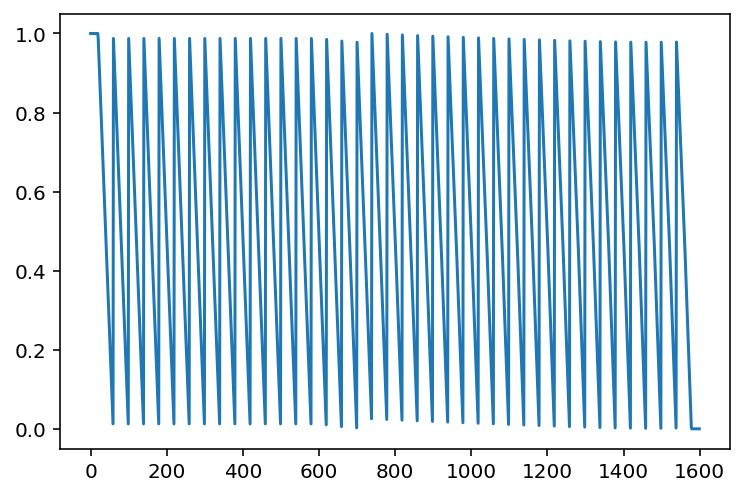

In [7]:
drf_finer,mapindex,mapfact,cellindex=finegrid.finegrid(np.squeeze(fine_drf[0:40]),np.squeeze(fine_drc[0:41]),[fine_drf[0:40].size,10])
plt.plot(mapfact)

In [8]:
import layers
thetalayers=np.linspace(4,21,80)
VH=layers.layers_1(ds_v.vo[0,0:40,100,100].values,
         ds_theta.thetao[0,0:40,100,100].values,thetalayers,mapfact,mapindex,cellindex,drf_finer)

In [9]:
VH.sum()

6.698477

In [10]:
v_in=ds_v.vo[10,0:40,:,:].squeeze()#.transpose('lev','time')
theta_in=ds_theta.thetao[10,0:40,:,:].squeeze()#.transpose('lev','time')
#original_shape = v_in.shape

#v_out,theta_out=core._reshape_inputs(v_in,theta_in)

In [11]:
#dimension order is (outside loop, inside loop)
#import layers
thetalayers=np.linspace(4,21,80)
#VH2=layers.loop_layers(v_out,
#         theta_out,thetalayers,mapfact,mapindex,cellindex,drf_finer)
#VH2.size

In [12]:
#new_shape=list(original_shape)
#new_shape[0]=thetalayers.size
#new_shape=tuple(new_shape)
#v_lay=np.squeeze(np.array(core._reshape_outputs(VH2, shape=new_shape)))

In [13]:
v_lay=core.layers_numpy(v_in,theta_in,thetalayers,mapfact,mapindex,cellindex,drf_finer)

In [17]:
v_lay.shape

(80, 384, 320)